In [5]:
i = 1
while i < 6:
    j = 0
    while j < i:
        print ("*")
        j += 1
    print("\n")
    i += 1

*


*
*


*
*
*


*
*
*
*


*
*
*
*
*




In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch.nn.parallel import DataParallel
from torch.cuda.amp import autocast, GradScaler
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    device = torch.device("cpu")
    print("GPU 不可用，将在 CPU 上运行")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
torch.cuda.empty_cache()  # 释放显存

cuda


In [2]:

#多因子预测
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks,preday):
        super(MyModel, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        self.preday=preday
        
        # 定义LSTM层
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2,batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        print(x.shape)
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        print(x.shape)
        # LSTM层
        lstm_out, _ = self.lstm(x)
        print('lstmout',lstm_out.shape)
        # 最后10个时间步的输出
        lstm_out = lstm_out[:, -self.preday:, :]
        print('最后时间步',lstm_out.shape)
        # 全连接层
        fc_out = self.fc(lstm_out)
        print('全连接层',fc_out.shape)
        # 批标准化层
        fc_out=fc_out.view(batch_size*self.num_stocks*self.preday,self.num_factors)
        factor_output = self.bn(fc_out)
        print('标准化层',factor_output.shape)
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks,self.preday, self.num_factors)
        
        # 计算c，这里直接求因子平均
        c = factor_output.mean(dim=3)
        print(c.shape)
        return factor_output
model = MyModel(6, 64, 1,0,5, 400,10)
x=torch.rand(4,60,400,6)
y=model(x)

torch.Size([4, 60, 400, 6])
torch.Size([1600, 60, 6])
lstmout torch.Size([1600, 60, 64])
最后时间步 torch.Size([1600, 10, 64])
全连接层 torch.Size([1600, 10, 5])
标准化层 torch.Size([16000, 5])
torch.Size([4, 400, 10])


In [5]:

# 定义标准化函数
def normalize_row(row):
    data = row.dropna()
    mean = np.mean(data)
    std = np.std(data)
    row[row.notna()] = (row[row.notna()] - mean) / std
    return row
df=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/adjopen.csv',index_col=0)
df.drop([x for x in df.columns if x[-2:]=='BJ'],axis=1,inplace=True)
dfopen = df.apply(normalize_row, axis=1)
df=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/adjclose.csv',index_col=0)
df.drop([x for x in df.columns if x[-2:]=='BJ'],axis=1,inplace=True)
dfclose = df.apply(normalize_row, axis=1)
df=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/adjhigh.csv',index_col=0)
df.drop([x for x in df.columns if x[-2:]=='BJ'],axis=1,inplace=True)
dfhigh = df.apply(normalize_row, axis=1)
df=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/adjlow.csv',index_col=0)
df.drop([x for x in df.columns if x[-2:]=='BJ'],axis=1,inplace=True)
dflow = df.apply(normalize_row, axis=1)
df=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/volume.csv',index_col=0)
df.drop([x for x in df.columns if x[-2:]=='BJ'],axis=1,inplace=True)
dfvolume = df.apply(normalize_row, axis=1)
df=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/vwap_adj.csv',index_col=0)
df.drop([x for x in df.columns if x[-2:]=='BJ'],axis=1,inplace=True)
dfvwap = df.apply(normalize_row, axis=1)
dfs=[dfclose,dfopen,dfhigh,dflow,dfvwap,dfvolume]

In [31]:
len(df[(df.index < 20200101) & (df.index>20100101)])

2431

In [7]:
dff=[]
for df in dfs:  #删除训练集时间段内未上市的
    df_filled = df[(df.index < 20200101) & (df.index>20100101)]
    df_filled=df_filled.dropna(axis=1,how='all') #删空列
    df_filled = df_filled.fillna(method='bfill')  #缺值回填
    dff.append(df_filled)

dfm=pd.concat(dff,axis=0,join='inner')
columns_to_drop = []
for column in dfm.columns: #若之后退市同样忽略
    # 将每列转换为布尔值，True表示空值，False表示非空值
    is_null = dfm[column].isnull()
    # 使用rolling函数计算连续空值的长度 
    consecutive_nulls = is_null.rolling(5, min_periods=1).sum()
    # 检查是否存在连续空值长度大于等于5的情况
    if any(consecutive_nulls >= 5):
        columns_to_drop.append(column)
for i in range(len(dff)):
    dff[i] = dff[i].drop(columns=columns_to_drop)
#再对齐一下列，不知道为什么concat后还是没对齐：
dfmm=pd.concat(dff,axis=0,join='inner')
for i in range(len(dff)):
    dff[i] = dff[i][dff[i].columns.intersection(dfmm.columns)]

dffval=[]
for df in dfs:  #删除训练集时间段内未上市的
    df_filled = df[(df.index < 20210101) & (df.index>20200101)]
    df_filled=df_filled.dropna(axis=1,how='all') #删空列
    df_filled = df_filled.fillna(method='bfill')  #缺值回填
    dffval.append(df_filled)

dfmval=pd.concat(dffval,axis=0,join='inner')
# columns_to_drop = []
# for column in dfm.columns: #若之后退市同样忽略
#     # 将每列转换为布尔值，True表示空值，False表示非空值
#     is_null = dfm[column].isnull()
#     # 使用rolling函数计算连续空值的长度 
#     consecutive_nulls = is_null.rolling(5, min_periods=1).sum()
#     # 检查是否存在连续空值长度大于等于5的情况
#     if any(consecutive_nulls >= 5):
#         columns_to_drop.append(column)
# for i in range(len(dff)):
#     dff[i] = dff[i].drop(columns=columns_to_drop)
#再对齐一下列，不知道为什么concat后还是没对齐：
for i in range(len(dff)):
    dffval[i] = dffval[i][dffval[i].columns.intersection(dfmval.columns)]

dfftest=[]
for df in dfs:  #删除测试集时间段内未上市的
    df_filled = df[(df.index < 20210601) & (df.index>=20210101)]
    df_filled=df_filled.dropna(axis=1,how='all')
    df_filled = df_filled.fillna(method='bfill')
    dfftest.append(df_filled)
for i in range(len(dff)):
    dfftest[i] = dfftest[i][dfftest[i].columns.intersection(dfmm.columns)]
dfmmtest=pd.concat(dfftest,axis=0,join='inner')
for i in range(len(dfftest)):
    dfftest[i] = dfftest[i][dfftest[i].columns.intersection(dfmmtest.columns)]

#训练集与验证集,测试集股票对齐
dfmmm=pd.concat([dfftest[0],dff[0],dffval[0]],axis=0,join='inner')
for i in range(len(dff)):
    dff[i] = dff[i][dff[i].columns.intersection(dfmmm.columns)]
for i in range(len(dff)):
    dfftest[i] = dfftest[i][dfftest[i].columns.intersection(dfmmm.columns)]
for i in range(len(dff)):
    dffval[i] = dffval[i][dffval[i].columns.intersection(dfmmm.columns)]

#装入tensor
time_length =2431
stock_code_length = 3726
T=60
# 创建一个空的三维数组，用于存放合并后的数据
X_tensor = np.zeros((time_length, stock_code_length, 6))

# 合并6个DataFrame的数据
for i, df in enumerate(dff):
    # 将DataFrame的值复制到对应的tensor切片中
    X_tensor[:, :, i] = df.values
X_tensor=torch.Tensor(X_tensor)
total_samples = 2372  # 指定总样本数量
time_steps_per_sample = 60  # 指定每个样本的时间步数
num_stocks = 3726  # 股票数量
num_features = 6  # 特征数量

# 初始化新的X_train
X_train = torch.zeros((total_samples, time_steps_per_sample, num_stocks, num_features))

# 将数据拆分成样本

for i in range(total_samples):
    end_idx = i + time_steps_per_sample
    X_train[i] = X_tensor[i:end_idx]

time_length =243
stock_code_length = 3726
T=60
# 创建一个空的三维数组，用于存放合并后的数据
X_tensorval = np.zeros((time_length, stock_code_length, 6))
# 合并6个DataFrame的数据
for i, df in enumerate(dffval):
    # 将DataFrame的值复制到对应的tensor切片中
    X_tensorval[:, :, i] = df.values
X_tensorval=torch.Tensor(X_tensorval)
total_samples = 184  # 指定总样本数量
# 初始化新的X_train
X_val = torch.zeros((total_samples, time_steps_per_sample, num_stocks, num_features))
# 将数据拆分成样本
for i in range(total_samples):
    end_idx = i + time_steps_per_sample
    X_val[i] = X_tensorval[i:end_idx]


time_length =97
stock_code_length = 3726
T=60
# 创建一个空的三维数组，用于存放合并后的数据
X_tensortest = np.zeros((time_length, stock_code_length, 6))
# 合并6个DataFrame的数据
for i, df in enumerate(dfftest):
    # 将DataFrame的值复制到对应的tensor切片中
    X_tensortest[:, :, i] = df.values
X_tensortest=torch.Tensor(X_tensortest)
total_samples = 38  # 指定总样本数量
# 初始化新的X_train
X_test = torch.zeros((total_samples, time_steps_per_sample, num_stocks, num_features))
# 将数据拆分成样本

for i in range(total_samples):
    end_idx = i + time_steps_per_sample
    X_test[i] = X_tensortest[i:end_idx]


In [4]:
close=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/adjclose.csv',index_col=0)
close.drop([x for x in close.columns if x[-2:]=='BJ'],axis=1,inplace=True)
ret=(close-close.shift(1))/close.shift(1)
ret= ret.fillna(method='bfill')
ret = ret.apply(normalize_row, axis=1) #标准化
ret1=ret[(ret.index <=20200115) & (ret.index>=20100101)]
ret1= ret1[ret1.columns.intersection(dff[0].columns)]
ret1=ret1.iloc[T:,]

In [8]:
close=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/adjclose.csv',index_col=0)
close.drop([x for x in close.columns if x[-2:]=='BJ'],axis=1,inplace=True)
ret=(close-close.shift(1))/close.shift(1)
ret= ret.fillna(method='bfill')
ret = ret.apply(normalize_row, axis=1) #标准化

ret1=ret[(ret.index <=20200102) & (ret.index>=20100101)]
ret1= ret1[ret1.columns.intersection(dff[0].columns)]
ret1=ret1.iloc[T:,]
array = ret1.to_numpy()  # 将DataFrame转换为NumPy数组
Y_train = np.reshape(array, ret1.shape)  # 将数组reshape为张量
Y_train=torch.Tensor(Y_train)

ret2=ret[(ret.index <=20210104) & (ret.index>20200101)]
ret2= ret2[ret2.columns.intersection(dff[0].columns)]
ret2=ret2.iloc[T:,]
array = ret2.to_numpy()  # 将DataFrame转换为NumPy数组
Y_val = np.reshape(array, ret2.shape)  # 将数组reshape为张量
Y_val=torch.Tensor(Y_val)

ret3=ret[(ret.index < 20210602) & (ret.index>=20210101)]
ret3= ret3[ret3.columns.intersection(dff[0].columns)]
ret3=ret3.iloc[T:,]
array = ret3.to_numpy()  # 将DataFrame转换为NumPy数组
Y_test = np.reshape(array, ret3.shape)  # 将数组reshape为张量
Y_test=torch.Tensor(Y_test)

window_size = 10  # 定义滑动窗口的大小，即连续的天数

# 生成新的训练集标签
ret1=ret[(ret.index <=20200115) & (ret.index>=20100101)]
ret1= ret1[ret1.columns.intersection(dff[0].columns)]
ret1=ret1.iloc[T:,]
Y_train_new = []
for i in range(len(ret1) - window_size + 1):
    window = ret1[i:i + window_size]
    Y_train_new.append(window)
Y_train_new = np.stack(Y_train_new)  # 转换为NumPy数组
Y_train_new = torch.Tensor(Y_train_new)

ret3=ret[(ret.index <= 20210615) & (ret.index>=20210101)]
ret3= ret3[ret3.columns.intersection(dff[0].columns)]
ret3=ret3.iloc[T:,]
Y_test_new = []
for i in range(len(ret3) - window_size + 1):
    window = ret3[i:i + window_size]
    Y_test_new.append(window)
Y_test_new = np.stack(Y_test_new)  # 转换为NumPy数组
Y_test_new = torch.Tensor(Y_test_new)

In [33]:
X_test.shape

torch.Size([38, 60, 3726, 6])

In [11]:
#class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_factors, num_stocks):
        super(MyModel, self).__init__()

        self.num_stocks = num_stocks
        
        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        
        # LSTM层
        lstm_out, _ = self.lstm(x)
        
        # 最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 全连接层
        fc_out = self.fc(lstm_out)
        
        # 批标准化层
        factor_output = self.bn(fc_out)
        
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks, num_factors)
        
        return factor_output

In [30]:
#多因子预测
class MyModelG(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks):
        super(MyModelG, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        
        # 定义LSTM层
        self.GRU = nn.GRU(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        
        # GRU
        lstm_out, _ = self.GRU(x)
        
        # 最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 全连接层
        fc_out = self.fc(lstm_out)
        
        # 批标准化层
        factor_output = self.bn(fc_out)
        
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks, self.num_factors)
        
        # 计算c，这里直接求因子平均
        c = factor_output.mean(dim=2)
        
        return factor_output

In [6]:
#多因子预测
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks):
        super(MyModel, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        
        # 定义LSTM层
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2,batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        
        # LSTM层
        lstm_out, _ = self.lstm(x)
        
        # 最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 全连接层
        fc_out = self.fc(lstm_out)
        
        # 批标准化层
        factor_output = self.bn(fc_out)
        
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks, self.num_factors)
        
        # 计算c，这里直接求因子平均
        c = factor_output.mean(dim=2)
        
        return factor_output

In [9]:
#预测未来10日
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks,preday):
        super(MyModel, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        self.preday=preday
        
        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        # LSTM层
        lstm_out, _ = self.lstm(x)
        # 最后10个时间步的输出
        lstm_out = lstm_out[:, -self.preday:, :]
        # 全连接层
        fc_out = self.fc(lstm_out)
        # 批标准化层
        fc_out=fc_out.view(batch_size*self.num_stocks*self.preday,self.num_factors)
        factor_output = self.bn(fc_out)
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks,self.preday, self.num_factors)
    
        c = factor_output.mean(dim=3)

        return factor_output

In [30]:
batch_size = 10
stocks = 5

y = torch.rand(batch_size, stocks)
c = torch.rand(batch_size, stocks)

# 将 Torch 张量转换为 NumPy 数组，以便使用 SciPy 函数
y_numpy = y.numpy()
c_numpy = c.numpy()

# 初始化一个存储所有样本的相关系数的列表
all_corr = []

# 计算每个样本的斯皮尔曼相关系数，并将结果添加到列表中
for i in range(batch_size):
    spearman_corr, _ = spearmanr(y_numpy[i], c_numpy[i])
    all_corr.append(spearman_corr)
# 计算每个批次的平均斯皮尔曼相关系数
batch_average_corr = np.mean(all_corr)

print(batch_average_corr)
# 假设你有一个形状为 (batch_size, stocks, 64) 的张量 tensor
x=torch.rand(4,400,64)
# 初始化一个空的DataFrame
df_list = []
# 按照 a 遍历Tensor并将每个二维数组转换为DataFrame的一行
for i in range(x.shape[0]):
    # 获取当前二维数组
    current_array = x[i].numpy()
    
    # 将二维数组转换为DataFrame的一行，并添加到列表中
    current_df = pd.DataFrame(current_array)
    df_list.append(current_df)

# 使用 concat 函数将所有DataFrame连接成一个
df = pd.concat(df_list, ignore_index=True)
cor=df.corr()
cor=cor*cor
cor=cor.replace(1,0)
penalty=cor.values.sum()/2

print(penalty)

0.11999999999999995


In [20]:
model = MyModel(6, 64, 1,0,5, 400,10)
x=torch.rand(4,60,400,6)
label=torch.rand(4,10,400)
y=model(x)
print(y.shape)
c = y.mean(dim=3)
print(c.shape)
print(label[0][0].shape)
print(Y_test_new.shape)
custom_loss_new(label, y)

torch.Size([4, 400, 10, 5])
torch.Size([4, 400, 10])
torch.Size([400])
torch.Size([38, 10, 3726])
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(3.4986, grad_fn=<MeanBackward0>)


tensor(3.4893, grad_fn=<AddBackward0>)

In [30]:
def custom_loss_new(y, factor_output):
    c = factor_output.mean(dim=3)
    corr=[]
    for i in range(c.shape[0]): #batch内循环
        ct=c[i].T #stocks*preday
        cin=[]
        for j in range(c.shape[2]):
            mean_c = torch.mean(ct[j])
            mean_y = torch.mean(y[i][j])
            
            # Calculate the numerator and denominators for Pearson correlation
            numerator = torch.sum((ct[j] - mean_c) * (y[i][j] - mean_y))
            denominator_c = torch.sqrt(torch.sum((ct[j] - mean_c)**2))
            denominator_y = torch.sqrt(torch.sum((y[i][j] - mean_y)**2))
            
            # Calculate the Pearson correlation coefficient
            pearson_corr = numerator / (denominator_c * denominator_y)
            cin.append(pearson_corr)
        corr.append(torch.stack(cin).mean())
    corr=torch.stack(corr).mean()
    print(corr)
    pen=[]
    for i in range(factor_output.shape[0]): #batch内循环
        penalty=[]
        tt= factor_output[i].transpose(0, 1)
        for j in range(tt.shape[0]): #天数内循环
            correlation_matrix = torch.corrcoef(tt[j].T)
            # 将对角线元素设置为零，即将每列与自身的相关系数剔除
            for i in range(len(correlation_matrix)):
                correlation_matrix[i, i] = 0
            # 计算相关系数的平方和
            zsum = torch.sum(correlation_matrix**2)
            penalty.append(zsum)
        pen.append(torch.stack(penalty).mean())
    pen=torch.stack(pen).mean()
    print(pen)
    loss=-corr+0.1*pen
    return loss

In [37]:
torch.cuda.empty_cache() 

In [38]:
# 数据准备：假设有num_stocks只股票，每只股票有num_features个特征
num_stocks = 3726
num_features = 6
T = 60  #时间步
num_epochs = 30
batch_size = 4

# 创建数据，X_train的形状应为(训练集总长, T, num_stocks, num_features)，y_train的形状应为(训练集总长, num_stocks)
# 模型构建

# 创建模型实例
input_size = num_features
hidden_size = 64
num_layers=1
dropout=0.1
num_factors = 60  #60个等权输出-天数？
preday=10
model = MyModel(input_size, hidden_size, num_layers,dropout,num_factors, num_stocks,preday)
best_spearman_corr=-1
# model = DataParallel(model)
model.to(device)  # 将模型移动到GPU


# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义学习率调度器，以在第10轮后降低学习率
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)
count=0
# 训练模型
loss_history = []
for epoch in range(num_epochs):
    torch.cuda.empty_cache() 
    loss_epoch = []
    for i in range(0, X_train.size(0)-4, batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = Y_train_new[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # 计算损失函数
        loss = custom_loss_new(labels, outputs)
            
        print(epoch, i, loss.item()/num_stocks)
        loss_epoch.append(loss.item()/num_stocks)
        loss.backward()
        optimizer.step()
    
    loss_history.append(np.mean(loss_epoch))
    
    # 调度学习率
    scheduler.step()
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} - Learning Rate: {current_lr}")

    #若loss比前一轮大则结束
    if epoch>=3 :
        if (loss.item()/num_stocks)>last:
            count+=1
            if count>=3:
                print('不收敛')
                break
    last=loss.item()/num_stocks


tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1405.9102, device='cuda:0', grad_fn=<MeanBackward0>)
0 0 0.0377303741340412
tensor(0.0108, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1147.3571, device='cuda:0', grad_fn=<MeanBackward0>)
0 4 0.03079036071744582
tensor(0.0128, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(967.5728, device='cuda:0', grad_fn=<MeanBackward0>)
0 8 0.025964699057693195
tensor(0.0142, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(848.2266, device='cuda:0', grad_fn=<MeanBackward0>)
0 12 0.022761258398149197
tensor(0.0149, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(757.7080, device='cuda:0', grad_fn=<MeanBackward0>)
0 16 0.02033168938104913
tensor(0.0162, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(697.9377, device='cuda:0', grad_fn=<MeanBackward0>)
0 20 0.018727219111165625
tensor(0.0189, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(671.4808, device='cuda:0', grad_fn=<MeanBackward0>)
0 24 0.01801642613966364
tensor(0.015

In [7]:
def custom_loss(y, factor_output):
    c = factor_output.mean(dim=2)
    corr=[]
    for i in range(c.shape[0]): #batch内循环
        # # 计算秩次差值
        # rank_X = torch.argsort(c[i].reshape(-1))
        # rank_Y = torch.argsort(y[i].reshape(-1))
        # differences = rank_X - rank_Y
        # # 计算斯皮尔曼秩相关系数
        # n = len(c[i])
        # spearman_corr = 1 - (6 * torch.sum(differences**2)) / (n * (n**2 - 1))
        # corr.append(spearman_corr)
        mean_c = torch.mean(c[i])
        mean_y = torch.mean(y[i])
        
        # Calculate the numerator and denominators for Pearson correlation
        numerator = torch.sum((c[i] - mean_c) * (y[i] - mean_y))
        denominator_c = torch.sqrt(torch.sum((c[i] - mean_c)**2))
        denominator_y = torch.sqrt(torch.sum((y[i] - mean_y)**2))
        
        # Calculate the Pearson correlation coefficient
        pearson_corr = numerator / (denominator_c * denominator_y)
        corr.append(pearson_corr)
    corr=torch.stack(corr).mean()
    penalty=[]
    for i in range(factor_output.shape[0]): #batch内循环
        correlation_matrix = torch.corrcoef(factor_output[i].T)
        # 将对角线元素设置为零，即将每列与自身的相关系数剔除
        for i in range(factor_output.shape[2]):
            correlation_matrix[i, i] = 0
        # 计算相关系数的平方和
        zsum = torch.sum(correlation_matrix**2)
        penalty.append(zsum)
    penalty=torch.stack(penalty).mean()
    loss=-corr+penalty
    return loss

In [62]:
y=torch.rand(4,400,1)
factor_output=torch.rand(4,400,60)
c = factor_output.mean(dim=2)
print(y.shape)
# print(factor_output.shape)
corr=[]
for i in range(c.shape[0]): #batch内循环
    print(c[i].shape)
    mean_c = torch.mean(c[i])
    mean_y = torch.mean(y[i])
    
    # Calculate the numerator and denominators for Pearson correlation
    numerator = torch.sum((c[i] - mean_c) * (y[i] - mean_y))
    denominator_c = torch.sqrt(torch.sum((c[i] - mean_c)**2))
    denominator_y = torch.sqrt(torch.sum((y[i] - mean_y)**2))
    
    # Calculate the Pearson correlation coefficient
    pearson_corr = numerator / (denominator_c * denominator_y)
    corr.append(pearson_corr)
corr=torch.stack(corr).mean()

factor_output=torch.rand(4,400,60)
penalty=[]
for i in range(factor_output.shape[0]): #batch内循环
    print(factor_output[i].shape)
    correlation_matrix = torch.corrcoef(factor_output[i].T)
    print(correlation_matrix.shape)
    # 将对角线元素设置为零，即将每列与自身的相关系数剔除
    for i in range(factor_output.shape[2]):
        correlation_matrix[i, i] = 0
    # 计算相关系数的平方和
    zsum = torch.sum(correlation_matrix**2)
    penalty.append(zsum)
    break
penalty=torch.stack(penalty).mean()



torch.Size([4, 400, 1])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400])
torch.Size([400, 60])
torch.Size([60, 60])


In [ ]:

#def custom_loss(y, factor_output):
    # 计算c与标签之间的相关系数的负值
    c = factor_output.mean(dim=2)
    
    # 将 c 和 y 转移到 CPU 上（如果尚未在 CPU 上）
    c = c.cpu()
    y = y.cpu()
    
    # 将 factor_output 转移到 CPU 上（如果尚未在 CPU 上）
    factor_output = factor_output.cpu()
    
    # 将 Torch 张量转换为 NumPy 数组，以便使用 SciPy 函数
    y_numpy = y.detach().numpy()
    c_numpy = c.detach().numpy()
    
    all_corr = []
    
    # 计算每个样本的斯皮尔曼相关系数，并将结果添加到列表中
    for i in range(c.shape[0]):
        spearman_corr, _ = spearmanr(y_numpy[i], c_numpy[i])
        all_corr.append(spearman_corr)
    
    # 计算相关系数损失
    loss = -torch.mean(torch.tensor(all_corr, dtype=torch.float32))
  
    # 初始化一个空的 DataFrame 列表
    df_list = []
    
    # 按照 a 遍历 Tensor 并将每个二维数组转换为 DataFrame 的一行
    for i in range(factor_output.shape[0]):
        # 获取当前二维数组
        current_array = factor_output[i].detach().numpy()
        
        # 将二维数组转换为 DataFrame 的一行，并添加到列表中
        current_df = pd.DataFrame(current_array)
        df_list.append(current_df)

    # 使用 concat 函数将所有 DataFrame 连接成一个
    df = pd.concat(df_list, ignore_index=True)
    cor = df.corr()
    cor = cor * cor
    cor = cor.replace(1, 0)
    
    # 计算惩罚项损失
    penalty = torch.tensor(cor.values.sum() / 2, dtype=torch.float32)
    
    # 最终的损失函数为两个损失项之和
    total_loss = loss + penalty
    total_loss.requires_grad_(True)
    return total_loss

In [7]:


#def custom_loss(y, factor_output):
    # 计算c与标签之间的相关系数的负值
    c = factor_output.mean(dim=2)
    
    # 将 c 和 y 转移到 CPU 上（如果尚未在 CPU 上）
    c = c.cpu()
    y = y.cpu()
    
    # 将 factor_output 转移到 CPU 上（如果尚未在 CPU 上）
    factor_output = factor_output.cpu()
    
    # 将 Torch 张量转换为 NumPy 数组，以便使用 SciPy 函数
    y_numpy = y.detach().numpy()
    c_numpy = c.detach().numpy()
    
    all_corr = []
    
    # 计算每个样本的斯皮尔曼相关系数，并将结果添加到列表中
    for i in range(c.shape[0]):
        spearman_corr, _ = spearmanr(y_numpy[i], c_numpy[i])
        all_corr.append(spearman_corr)
    
    # 计算相关系数损失
    loss = -torch.mean(torch.tensor(all_corr, dtype=torch.float32))
  
    # 初始化一个空的 DataFrame 列表
    df_list = []
    
    # 按照 a 遍历 Tensor 并将每个二维数组转换为 DataFrame 的一行
    for i in range(factor_output.shape[0]):
        # 获取当前二维数组
        current_array = factor_output[i].detach().numpy()
        
        # 将二维数组转换为 DataFrame 的一行，并添加到列表中
        current_df = pd.DataFrame(current_array)
        df_list.append(current_df)

    # 使用 concat 函数将所有 DataFrame 连接成一个
    df = pd.concat(df_list, ignore_index=True)
    cor = df.corr()
    cor = cor * cor
    cor = cor.replace(1, 0)
    
    # 计算惩罚项损失
    penalty = torch.tensor(cor.values.sum() / 2, dtype=torch.float32)
    
    # 最终的损失函数为两个损失项之和
    total_loss = loss + penalty
    total_loss.requires_grad_(True)
    return total_loss

In [23]:
torch.cuda.empty_cache()  # 释放显存
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()


In [ ]:

# 数据准备：假设有num_stocks只股票，每只股票有num_features个特征
num_stocks = 3726
num_features = 6
T = 60  #时间步
num_epochs = 20
batch_size = 4

# 创建数据，X_train的形状应为(训练集总长, T, num_stocks, num_features)，y_train的形状应为(训练集总长, num_stocks)
# 模型构建

# 创建模型实例
input_size = num_features
hidden_size = 64
num_factors = 60  #60个等权输出-天数？

model = MyModel(input_size, hidden_size, num_factors, num_stocks)

# model = DataParallel(model)
model.to(device)  # 将模型移动到GPU


# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义学习率调度器，以在第10轮后降低学习率
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=1)

# 训练模型
loss_history = []
for epoch in range(num_epochs):
    torch.cuda.empty_cache() 
    loss_epoch = []
    for i in range(0, X_train.size(0)-4, batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = Y_train[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # 计算损失函数
        loss = custom_loss(labels, outputs)
            
        print(epoch, i, loss.item()/num_stocks)
        loss_epoch.append(loss.item()/num_stocks)
        loss.backward()
        optimizer.step()
    
    loss_history.append(np.mean(loss_epoch))
    
    # 调度学习率
    scheduler.step()
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} - Learning Rate: {current_lr}")


In [55]:
torch.cuda.empty_cache()

In [ ]:
# 数据准备：假设有num_stocks只股票，每只股票有num_features个特征
num_stocks = 3726
num_features = 6
T = 60  #时间步
num_epochs = 30
batch_size = 4

# 创建数据，X_train的形状应为(训练集总长, T, num_stocks, num_features)，y_train的形状应为(训练集总长, num_stocks)
# 模型构建

# 创建模型实例
input_size = num_features
hidden_size = 64
num_layers=3
dropout=0.1
num_factors = 60  #60个等权输出-天数？

model = MyModelG(input_size, hidden_size, num_layers,dropout,num_factors, num_stocks)
best_spearman_corr=-1
# model = DataParallel(model)
model.to(device)  # 将模型移动到GPU


# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 定义学习率调度器，以在第10轮后降低学习率
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)
count=0
# 训练模型
loss_history = []
for epoch in range(num_epochs):
    torch.cuda.empty_cache() 
    loss_epoch = []
    for i in range(0, X_train.size(0)-4, batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = Y_train[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # 计算损失函数
        loss = custom_loss(labels, outputs)
            
        print(epoch, i, loss.item()/num_stocks)
        loss_epoch.append(loss.item()/num_stocks)
        loss.backward()
        optimizer.step()
    
    loss_history.append(np.mean(loss_epoch))
    
    # 调度学习率
    scheduler.step()
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} - Learning Rate: {current_lr}")

    #若loss比前一轮大则结束
    if epoch>=3 :
        if (loss.item()/num_stocks)>last:
            count+=1
            if count>=3:
                print('不收敛')
                break
    last=loss.item()/num_stocks
    # 在验证集上计算斯皮尔曼相关系数
#     with torch.no_grad():
#         torch.cuda.empty_cache() 
#         c = []
#         for i in range(0, X_val.size(0)-4, batch_size):
#             input_sample = X_val[i:i+batch_size].to(device)
#             label_sample = Y_val[i:i+batch_size].to(device)
#             # input_sample = X_val  # 获取单个样本并添加批次维度
#             # label_sample = Y_val
#             # 使用模型进行推理并获取单个样本的预测输出（c值）
#             factors = model(input_sample)
#             c_value=factors.mean(dim=2)
#             print(c_value.shape)
#             corr2=[]
#             for i in range(c_value.shape[0]): 
#                 rank_X = torch.argsort(c_value[i].reshape(-1))
#                 rank_Y = torch.argsort(label_sample[i].reshape(-1))
#                 differences = rank_X - rank_Y
#                 # 计算斯皮尔曼秩相关系数
#                 n = len(c_value[i])
#                 spearman_corr = 1 - (6 * torch.sum(differences**2)) / (n * (n**2 - 1))
#                 print(spearman_corr)
#                 corr2.append(spearman_corr)
#             # 更新最佳斯皮尔曼相关系数和模型权重
#             corr2=sum(corr2)/len(corr2)
#             c.append(corr2)
#         c=sum(c)/len(c)
#         if c > best_spearman_corr:
#             best_spearman_corr = c
#             best_model_weights = model.state_dict()
#         print(best_spearman_corr)
#     # 如果斯皮尔曼相关系数达到了某个停止条件，可以提前停止训练
#     if best_spearman_corr >= 0.2:
#         print(f"Training stopped early at Epoch {epoch + 1} because of achieving the desired Spearman correlation.")
#         break

# # 使用最佳模型权重
# model.load_state_dict(best_model_weights)

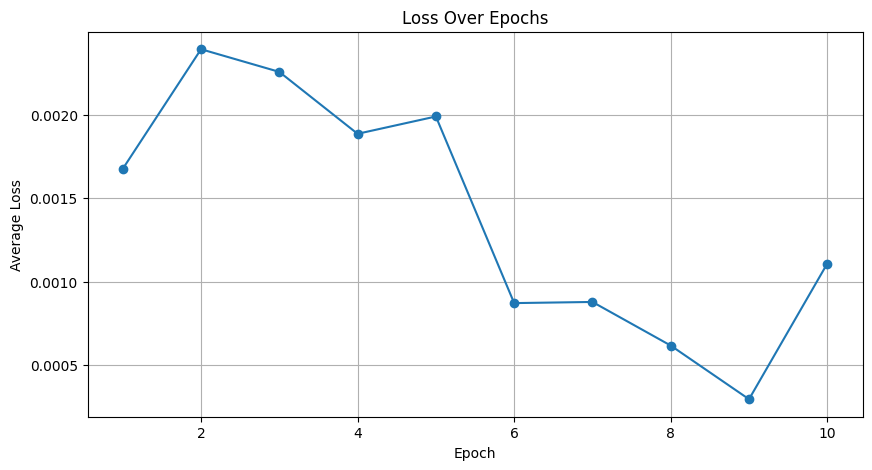

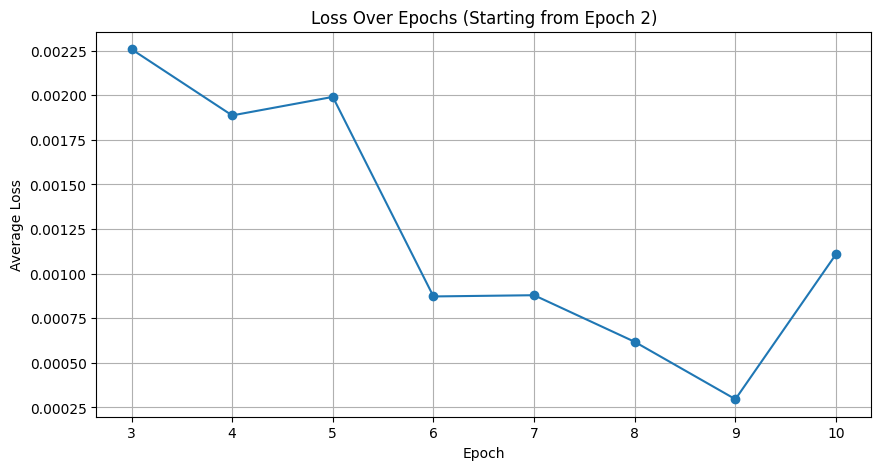

In [39]:
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(loss_history) + 1)
    plt.plot(epochs, loss_history, marker='o', linestyle='-')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

plot_loss(loss_history)
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    epochs = range(3, len(loss_history) + 1)  # 从第二轮开始绘制，所以范围从2开始
    plt.plot(epochs, loss_history[2:], marker='o', linestyle='-')  # 从第二轮开始绘制，所以从索引1开始
    plt.title('Loss Over Epochs (Starting from Epoch 2)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

# 调用修改后的函数以绘制损失图
plot_loss(loss_history)

In [40]:
# 保存模型参数
torch.save(model.state_dict(), 'model_params_long1_pre10.pth')


In [23]:
dfftest=[]
for df in dfs:  #删除测试集时间段内未上市的
    df_filled = df[(df.index < 20211231) & (df.index>=20210101)]
    df_filled=df_filled.dropna(axis=1,how='all')
    df_filled = df_filled.fillna(method='bfill')
    dfftest.append(df_filled)
for i in range(len(dff)):
    dfftest[i] = dfftest[i][dfftest[i].columns.intersection(dfmm.columns)]
print(dfftest[0].shape)
time_length =242
stock_code_length = 4121
T=60
# 创建一个空的三维数组，用于存放合并后的数据
X_tensortest = np.zeros((time_length, stock_code_length, 6))

# 合并6个DataFrame的数据
for i, df in enumerate(dfftest):
    # 将DataFrame的值复制到对应的tensor切片中
    X_tensortest[:, :, i] = df.values
X_tensortest=torch.Tensor(X_tensortest)
total_samples = 183  # 指定总样本数量
time_steps_per_sample = 60  # 指定每个样本的时间步数
num_stocks = 4121  # 股票数量
num_features = 6  # 特征数量

# 初始化新的X_train
X_test1 = torch.zeros((total_samples, time_steps_per_sample, num_stocks, num_features))

# 将数据拆分成样本

for i in range(total_samples):
    end_idx = i + time_steps_per_sample
    X_test1[i] = X_tensortest[i:end_idx]

close=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/adjclose.csv',index_col=0)
close.drop([x for x in close.columns if x[-2:]=='BJ'],axis=1,inplace=True)
ret=(close-close.shift(1))/close.shift(1)
ret= ret.fillna(method='bfill')
ret=ret[(ret.index <= 20211231) & (ret.index>=20210101)]
ret= ret[ret.columns.intersection(dff[0].columns)]
ret=ret.iloc[T:,]
array = ret.to_numpy()  # 将DataFrame转换为NumPy数组
Y_test1 = np.reshape(array, ret.shape)  # 将数组reshape为张量
Y_test1=torch.Tensor(Y_test1)

(242, 4121)


In [ ]:
model = MyModelG(6,64,60,3726)
# 加载保存的模型参数
model.load_state_dict(torch.load('model_params_long2d.pth'))
with torch.no_grad():
    factors=model(X_test)
    print(factors)

In [ ]:
state_dict = torch.load("model_params_long2_gruu.pth")
for i in state_dict:
    print(i)
    print((state_dict[i]))


In [44]:
Y_test.shape

torch.Size([38, 3726])

In [54]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

#input_size, hidden_size,num_layers,dropout, num_factors, num_stocks
model = MyModel(input_size, hidden_size, num_layers,dropout,num_factors, num_stocks,preday)
# 加载保存的模型参数
model.load_state_dict(torch.load('model_params_long1_pre10.pth'))

# 设置模型为评估模式
model.eval()
ic_values = []

with torch.no_grad():
    input_sample = X_test  # 获取单个样本并添加批次维度
    label_sample = Y_test_new
    # 使用模型进行推理并获取单个样本的预测输出（c值）
    factors = model(input_sample)
    c_value=factors.mean(dim=3)
    print(c_value.shape)
    print(label_sample.shape)
    c1=[]
    c2=[]
    for i in range(c_value.shape[0]): 
        cv=c_value[i].T
        corr1=[]
        corr2=[]
        for j in range(cv.shape[0]):
            # 创建遮罩以识别c_value和Y_test中的非NaN值
            mask_c = ~torch.isnan(cv[j])
            mask_y = ~torch.isnan(label_sample[i][j])
            
            # 组合这些遮罩以获取c_value和Y_test的共同遮罩
            mask = mask_c & mask_y
            
            # 将遮罩应用于张量
            c_value_filtered = cv[j][mask]
            Y_test_filtered = label_sample[i][j][mask]

        
            # 计算每个输入的均值
            mean_c = torch.mean(c_value_filtered)
            mean_y = torch.mean(Y_test_filtered)
            # print(mean_c,mean_y)
            # 计算皮尔逊相关系数的分子和分母
            numerator = torch.sum((c_value_filtered - mean_c) * (Y_test_filtered - mean_y))
            # print(numerator)
            denominator_c = torch.sqrt(torch.sum((c_value_filtered - mean_c)**2))
            denominator_y = torch.sqrt(torch.sum((Y_test_filtered - mean_y)**2))

            # 计算皮尔逊相关系数
            pearson_corr = numerator / (denominator_c * denominator_y)
            corr1.append(pearson_corr.item())
            # 计算秩次差值
            rank_X = torch.argsort(cv[j].reshape(-1))
            rank_Y = torch.argsort(label_sample[i][j].reshape(-1))
            differences = rank_X - rank_Y
            # 计算斯皮尔曼秩相关系数
            n = len(c_value[i])
            spearman_corr = 1 - (6 * torch.sum(differences**2)) / (n * (n**2 - 1))
            corr2.append(spearman_corr)
        c1.append(np.mean(corr1))
        c2.append(np.mean(corr2))
    c1=np.mean(c1)
    c2=np.mean(c2)
    print('Pearson:',c1)
    print('Spearman:',c2)


/home/jmchen/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([38, 3726, 10])
torch.Size([38, 10, 3726])
Pearson: -0.001818733952227615
Spearman: 0.00091653503


In [46]:
# 创建一个与您训练模型相同的模型实例
model = MyModel(input_size, hidden_size, num_layers,dropout,num_factors, num_stocks,preday)

# 加载训练好的模型参数
model.load_state_dict(torch.load('model_params.pth'))
model.to(device)
batch_size = 2  # 适当调整批次大小，以适应您的GPU内存
num_samples = X_test.size(0)
num_batches = (num_samples + batch_size - 1) // batch_size  # 向上取整

# 初始化变量以跟踪正确的预测数
correct_predictions = 0

# 将模型设置为评估模式（不使用dropout等）
model.eval()

# 逐批次进行推断
with torch.no_grad():  # 禁用梯度计算，因为在推断时不需要梯度
    for batch_idx in range(num_batches):
        # 获取当前批次的起始和结束索引
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)

        # 获取当前批次的输入数据和标签
        batch_X = X_test[start_idx:end_idx]
        batch_Y = Y_test[start_idx:end_idx]

        # 将批次数据移动到GPU
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        # 进行模型推断
        batch_outputs = model(batch_X)

        # 计算当前批次的正确预测数
        predicted_labels = torch.argmax(batch_outputs, dim=1)
        correct_predictions += (predicted_labels == batch_Y).sum().item()

# 计算整体准确率
total_samples = num_samples
accuracy = correct_predictions / total_samples
print("Test Accuracy:", accuracy)

/home/jmchen/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RuntimeError: Error(s) in loading state_dict for MyModel:
	size mismatch for fc.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([60, 64]).
	size mismatch for fc.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for bn.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for bn.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for bn.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for bn.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([60]).

In [ ]:
# 数据准备：假设有num_stocks只股票，每只股票有num_features个特征
num_stocks = 4165
num_features = 6
T = 60  # 假设时间步为30
num_epochs = 20
batch_size = 2

# 创建数据，X_train的形状应为(训练集总长, T, num_stocks, num_features)，y_train的形状应为(训练集总长, num_stocks)
X_train
Y_train 

# 模型构建

# 创建模型实例
input_size = num_features
hidden_size = 64
num_factors = 1  #60个等权输出？

model = MyModel(input_size, hidden_size, num_factors, num_stocks)


model = DataParallel(model)
model.to(device)  # 将模型移动到GPU
X_train = X_train.to(device)  # 将训练数据移动到GPU
Y_train = Y_train.to(device)  # 将训练标签移动到GPU

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()
for epoch in range(num_epochs):
    torch.cuda.empty_cache()  # 释放显存
    for i in range(0, X_train.size(0), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = Y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        
        # 使用autocast开启混合精度计算
        with autocast():
            outputs = model(inputs)
            
            loss = 0
            for j in range(num_stocks):
                mse_loss = F.mse_loss(outputs[:, j, :], labels[:, j], reduction='mean')
                loss += mse_loss
            
            # 缩放损失值
            loss = loss / num_stocks
            scaler.scale(loss).backward()
            
        # 使用scaler.step来更新模型参数
        scaler.step(optimizer)
        scaler.update()
        
        print(epoch, i, loss.item())


In [ ]:
import gc
def report_gpu():
   print(torch.cuda.list_gpu_processes())
   gc.collect()
   torch.cuda.empty_cache()
report_gpu()